# Sampling CoCo image dataset to train and use DPM on

In [1]:
import json
import random
from pycocotools.coco import COCO
import requests
import os
import shutil
from tqdm import tqdm

from xml.etree.ElementTree import Element, SubElement, ElementTree, tostring 
from xml.dom.minidom import parseString 

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

from collections import defaultdict

We clear the folders beforehand

In [2]:
def clear_folder(folder_path):
    """
    Clears all files and subdirectories in the specified folder.

    Args:
        folder_path (str): Path to the folder to clear.
    """
    if os.path.exists(folder_path):
        # Remove all contents of the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Remove file or symbolic link
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Remove directory
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        # If folder doesn't exist, create it
        os.makedirs(folder_path)


Helper function to make PASCAL VOC-style XML annotations.

In [3]:
# Function to create Pascal-style XML annotations
def create_pascal_xml(img_info, annotations, output_annotation_dir, categories):
    """
    Generates a Pascal VOC-style XML file for a given image and its annotations.

    Args:
    - img_info (dict): Image metadata from COCO.
    - annotations (list): List of annotations for the image.
    - output_annotation_dir (str): Directory to save the XML file.
    - categories (list): List of category names to include in the annotations.
    """
    from xml.etree.ElementTree import Element, SubElement, tostring
    from xml.dom.minidom import parseString
    import os

    xml_root = Element('annotation')
    folder = SubElement(xml_root, 'folder')
    folder.text = 'VOC2007'

    filename = SubElement(xml_root, 'filename')
    filename.text = img_info['file_name']

    # default source
    source = SubElement(xml_root, 'source')
    database = SubElement(source, 'database')
    database.text = 'COCO Database'

    image = SubElement(source, 'image')
    image.text = 'flickr'

    annotation_tag = SubElement(source, 'annotation')
    annotation_tag.text = 'PASCAL VOC2007'

    flicker_id = SubElement(source, 'flickerid')
    flicker_id.text = '341012865'

    # default owner
    owner = SubElement(xml_root, 'owner')
    flicker_id = SubElement(owner, 'flickerid')
    flicker_id.text = 'Default owner'
    owner_name = SubElement(owner, 'name')
    owner_name.text = 'Default ownername'

    size = SubElement(xml_root, 'size')
    SubElement(size, 'width').text = str(img_info['width'])
    SubElement(size, 'height').text = str(img_info['height'])
    SubElement(size, 'depth').text = '3'  # Assuming RGB images

    segmented = SubElement(xml_root, 'segmented')
    segmented.text = '0'

    for ann in annotations:
        # Include only objects in the specified categories
        cat_id = ann['category_id']
        if cat_id not in id_categories.keys():
            continue

        obj = SubElement(xml_root, 'object')
        name = SubElement(obj, 'name')
        cat_name = id_categories[cat_id]
        name.text = cat_name  # Category name from COCO annotation

        # Default difficulty 0
        difficult = SubElement(obj, 'difficult')
        difficult.text = '0'
        
        # Default pose and truncated values
        pose = SubElement(obj, 'pose')
        pose.text = 'Unspecified'

        truncated = SubElement(obj, 'truncated')
        bbox = ann['bbox']  # COCO format: [xmin, ymin, width, height]
        x_min = bbox[0]
        y_min = bbox[1]
        x_max = bbox[0] + bbox[2]
        y_max = bbox[1] + bbox[3]
        is_truncated = (
            x_min < 0 or y_min < 0 or x_max > img_info['width'] or y_max > img_info['height']
        )
        truncated.text = '1' if is_truncated else '0'

        # Bounding box
        bndbox = SubElement(obj, 'bndbox')
        SubElement(bndbox, 'xmin').text = str(max(0, int(x_min)))  # Clip to image boundaries
        SubElement(bndbox, 'ymin').text = str(max(0, int(y_min)))
        SubElement(bndbox, 'xmax').text = str(min(img_info['width'], int(x_max)))
        SubElement(bndbox, 'ymax').text = str(min(img_info['height'], int(y_max)))

    # If no relevant annotations, skip saving the XML
    if not any(cat_name in categories for ann in annotations):
        print(f"Skipping XML generation for {img_info['file_name']} - no relevant annotations.")
        return

    # Pretty format 
    asstring = tostring(xml_root, 'utf-8')
    parsed_xml = parseString(asstring)
    pretty_xml = parsed_xml.toprettyxml(indent="\t")

    # Remove the XML declaration manually
    pretty_xml = '\n'.join(pretty_xml.splitlines()[1:])

    # Save XML
    output_file = os.path.join(output_annotation_dir, f"{os.path.splitext(img_info['file_name'])[0]}.xml")
    with open(output_file, 'w') as f:
        f.write(pretty_xml)


In [4]:
# downloading 2000 images of training data for category person
# Paths
keypoints_annotation_file = 'annotations/person_keypoints_train2017.json'  # Update with your COCO annotation file path
annotation_file = 'annotations/instances_train2017.json'  # Update with your COCO annotation file path
output_dir = '/Users/junitasirait/dpmp/VOCdevkit/VOC2007_coco'  # Folder to save downloaded images
annotations_dir = os.path.join(output_dir, 'Annotations')
sets_dir = os.path.join(output_dir, 'ImageSets', 'Main')
images_dir = os.path.join(output_dir, 'JPEGImages')

In [7]:
# Load COCO annotations
coco_all_anno = COCO(annotation_file)

loading annotations into memory...
Done (t=11.94s)
creating index...
index created!


In [5]:
categories = [
    'airplane', 
    'bicycle', 
    'bird', 
    'boat', 
    'bottle', 
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'dining table',
    'dog', 
    'horse', 
    'motorcycle', 
    'person', 
    'potted plant',
    'sheep',
    'couch',
    'train', 
    'TV',
    # parts
    'head',
    'torso', 
    'arm',
]

In [8]:
category_ids = {cat['name']: cat['id'] for cat in coco_all_anno.loadCats(coco_all_anno.getCatIds()) if cat['name'] in categories}
# parts
category_ids['head'] = 100
category_ids['torso'] = 101
category_ids['arm'] = 102
id_categories = {v:k for (k,v) in category_ids.items()}
# category_ids
category_ids

{'person': 1,
 'bicycle': 2,
 'car': 3,
 'motorcycle': 4,
 'airplane': 5,
 'bus': 6,
 'train': 7,
 'boat': 9,
 'bird': 16,
 'cat': 17,
 'dog': 18,
 'horse': 19,
 'sheep': 20,
 'cow': 21,
 'bottle': 44,
 'chair': 62,
 'couch': 63,
 'potted plant': 64,
 'dining table': 67,
 'head': 100,
 'torso': 101,
 'arm': 102}

In [568]:
# Define split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

all_images = set()
# Track globally selected image IDs to avoid duplicates
globally_selected_image_ids = set()
random.seed(429)

# Prepare data structures
# train_txt_path = os.path.join(sets_dir, "train.txt")
# category_txt_files = {category: open(os.path.join(sets_dir, f"{category}_train.txt"), "w") for category in categories}
positive_samples = {category: set() for category in categories}
annotations_by_image = {}

# Prepare split-specific data structures
splits = {
    "train": {"image_ids": set(), "annotations": {}, "images": set()},
    "val": {"image_ids": set(), "annotations": {}, "images": set()},
    "test": {"image_ids": set(), "annotations": {}, "images": set()},
    "trainval": {"image_ids": set(), "annotations": {}, "images": set()}
}

# Initialize global variables
all_images = set()  # To track downloaded images
globally_selected_image_ids = set()  # Track globally selected image IDs
random.seed(429)  # Ensure reproducibility

# Ensure image directory exists
os.makedirs(images_dir, exist_ok=True)

# Process each category
for category, category_id in tqdm(category_ids.items(), desc="Processing categories"):
    print(f"Processing category: {category}")
    
    # Handle 'person' category separately
    if category == 'person':
        instance_target = person_instance_target
        instance_count = 0
        selected_image_ids = []
        image_ids = coco.getImgIds(catIds=[category_id])
        random.shuffle(image_ids)

        # Collect images until the instance target is reached
        for img_id in image_ids:
            print(f"Person count now: {instance_count}")
            if img_id in globally_selected_image_ids:
                continue
            ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=[category_id])
            person_count = len(ann_ids)
            if instance_count + person_count <= instance_target:
                selected_image_ids.append(img_id)
                globally_selected_image_ids.add(img_id)
                instance_count += person_count
            else:
                break
        print(f"Selected {len(selected_image_ids)} images to meet {instance_count} 'person' instances.")
    else:
        # Default behavior for other categories
        image_ids = coco.getImgIds(catIds=[category_id])
        random.shuffle(image_ids)
        selected_image_ids = []
        for img_id in image_ids:
            if img_id in globally_selected_image_ids:
                continue
            selected_image_ids.append(img_id)
            globally_selected_image_ids.add(img_id)
            if len(selected_image_ids) >= num_images_per_category:
                break
    print(f"Selected {len(selected_image_ids)} unique images for category {category}.")

    # Split selected images into train, val, and test
    random.shuffle(selected_image_ids)
    num_images = len(selected_image_ids)
    train_end = int(num_images * train_ratio)
    val_end = train_end + int(num_images * val_ratio)
    print(f"num_immages: {num_images}, train_end: {train_end}, val_end: {val_end}")

    splits["train"]["image_ids"].update(selected_image_ids[:train_end])
    splits["val"]["image_ids"].update(selected_image_ids[train_end:val_end])
    splits["test"]["image_ids"].update(selected_image_ids[val_end:])

    # Collect annotations and positive samples
    for split in ["train", "val", "test"]:
        for img_id in splits[split]["image_ids"]:
            annotations = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))
            splits[split]["annotations"][img_id] = annotations
            splits[split]["images"].add(
                os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
            )
            # Update positive samples
            for ann in annotations:
                cat_id = ann['category_id']
                if cat_id in id_categories.keys():
                    positive_samples[id_categories[cat_id]].add(
                        os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
                    )

# Create trainval split (combine train and val)
splits["trainval"]["image_ids"] = splits["train"]["image_ids"].union(splits["val"]["image_ids"])
splits["trainval"]["annotations"] = {**splits["train"]["annotations"], **splits["val"]["annotations"]}
splits["trainval"]["images"] = splits["train"]["images"].union(splits["val"]["images"])

# Download images and create XML annotations for each split
for split, data in splits.items():
    for img_id, annotations in tqdm(data["annotations"].items(), desc=f"Processing {split} images"):
        img_info = coco.loadImgs(img_id)[0]
        img_filename = os.path.splitext(img_info['file_name'])[0]
        img_filepath = os.path.join(images_dir, img_info['file_name'])

        # Download the image if not already downloaded
        if img_filename not in all_images:
            if not os.path.exists(img_filepath):
                try:
                    response = requests.get(img_info['coco_url'], stream=True, timeout=10)
                    response.raise_for_status()
                    with open(img_filepath, 'wb') as f:
                        for chunk in response.iter_content(1024):
                            f.write(chunk)
                except requests.exceptions.RequestException as e:
                    print(f"Failed to download {img_info['file_name']}: {e}")
                    continue  # Skip this image on failure

            all_images.add(img_filename)

        # Generate XML annotation
        create_pascal_xml(img_info, annotations, annotations_dir, categories)

# Write ImageSets files for each split
for split, data in splits.items():
    txt_path = os.path.join(sets_dir, f"{split}.txt")
    with open(txt_path, "w") as file:
        for img_filename in sorted(data["images"]):
            file.write(f"{img_filename}\n")

    # Write category-specific files
    for category in categories:
        category_txt_path = os.path.join(sets_dir, f"{category}_{split}.txt")
        with open(category_txt_path, "w") as category_file:
            for img_filename in sorted(data["images"]):
                label = "1" if img_filename in positive_samples[category] else "-1"
                category_file.write(f"{img_filename} {label}\n")

print(f"ImageSets for train, val, test, and trainval created at {sets_dir}.")


Processing categories:   0%|                              | 0/4 [00:00<?, ?it/s]

Processing category: person


NameError: name 'person_instance_target' is not defined

## Sampling for parts

### Explorations

In [9]:
coco = COCO(keypoints_annotation_file)

loading annotations into memory...
Done (t=7.30s)
creating index...
index created!


idcs_to_show: [51, 52, 53]
image id: 263041


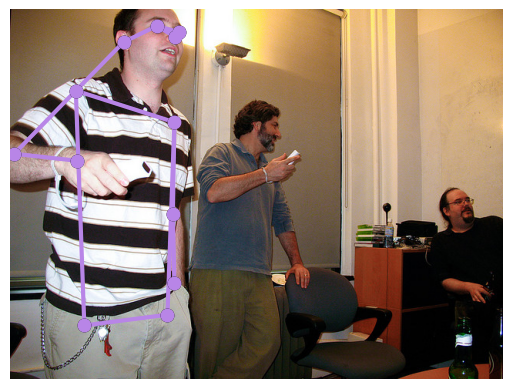

In [672]:
# random.seed(429)
person_sample = random.sample(sorted(coco.getImgIds(catIds=[1])), 1)[0]
person_sample = 263041  # 579267  # 168215, 26817, 178557, 345100, 115146, 555537, 431555, 245415
person_sample

# Let's select one image to visualize
img_id = person_sample
annotation_ids = coco.getAnnIds(imgIds=img_id, catIds=[1])
annotation_id = annotation_ids[0]
len(annotation_ids), annotation_ids[0]

loaded_annotations = coco.loadAnns(ids=annotation_ids)
len(loaded_annotations)

# download image 
image_info = coco.loadImgs(img_id)[0]
response = requests.get(image_info['coco_url'])
image = Image.open(BytesIO(response.content))

# let's visualize the keypoints one by one 
kp_vis = 17
idcs_to_show = [kp_vis*3, kp_vis*3+1, kp_vis*3+2]
print(f"idcs_to_show: {idcs_to_show}")
kp_mask = [1 if i in idcs_to_show else 0 for i in range(51)]
original_keypoints = loaded_annotations[0]['keypoints']
kps = [original_keypoints[i] if kp_mask[i] else 0 for i in range(51)]

original_annotation = {
    # 'keypoints': kps, 
    'keypoints': original_keypoints, 
    'category_id': 1,
}

print(f"image id: {person_sample}")
plt.imshow(image)
plt.axis('off')
coco.showAnns([original_annotation], draw_bbox=False)

# according to 206431 need to also consider shoulders most likely
# silly examples: 369872, 178166, 567671

In [232]:
loaded_annotations[0].keys()

dict_keys(['segmentation', 'num_keypoints', 'area', 'iscrowd', 'keypoints', 'image_id', 'bbox', 'category_id', 'id'])

In [82]:
# looking at length of keypoints 
[len(a['keypoints']) for a in loaded_annotations]

# so we know that this length is always 51 -- if a keypoint does not exist then it is represented as 0,0,0

[51, 51]

In [10]:
# Keypoints
kpd = {
    0: 'nose', 
    1: 'left_eye', 
    2: 'right_eye', 
    3: 'left_ear', 
    4: 'right_ear', 
    5: 'left_shoulder', 
    6: 'right_shoulder', 
    7: 'left_elbow', 
    8: 'right_elbow', 
    9: 'left_wrist', 
    10: 'right_wrist', 
    11: 'left_hip', 
    12: 'right_hip', 
    13: 'left_knee', 
    14: 'right_knee', 
    15: 'left_ankle', 
    16: 'right_ankle', 
}


In [312]:
# Part 1: Head. Keypoints: 0, 5, 6.
# Part 2: Torso. Keypoints: 5, 6, 11, 12. 
# Part 3: Lower arm. Keypoints: 7/8, 9/10, with pad half the length (all sides). 
# Part 4: Lower legs. Keypoints: 13/14, 15/16, with pad half the length (all sides).

# visibility 2 -- visible and labelled

### Parts

In [27]:
def is_head_present(person_annotation_keypoints):
    # given an annotation from 'person' category, we check if head part is present 
    # original_keypoints = person_annotation['keypoints']
    nose_visible = person_annotation_keypoints[2]
    leftshoulder_visible = person_annotation_keypoints[17]
    rightshoulder_visible = person_annotation_keypoints[20]
    return nose_visible==2 and leftshoulder_visible==2 and rightshoulder_visible==2

def is_leftarm_present(person_annotation_keypoints):
    # original_keypoints = person_annotation['keypoints']
    leftelbow_visible = person_annotation_keypoints[23]
    leftwrist_visible = person_annotation_keypoints[29]
    return leftelbow_visible==2 and leftwrist_visible==2

def is_rightarm_present(person_annotation_keypoints):
    # original_keypoints = person_annotation['keypoints']
    rightelbow_visible = person_annotation_keypoints[26]
    rightwrist_visible = person_annotation_keypoints[32]
    return rightelbow_visible==2 and rightwrist_visible==2

def is_only_head_present(person_annotation_keypoints):
    # original_keypoints = person_annotation['keypoints']
    visibilities = person_annotation_keypoints[20:len(person_annotation_keypoints):3]
    return sum(visibilities) < 5

In [28]:
# Getting bounding boxes in the style of COCO annotation

def get_head_bbox(person_annotation):
    original_keypoints = person_annotation['keypoints']
    nose_x, nose_y, nose_visible = original_keypoints[0:3]
    leftshoulder_x, leftshoulder_y, leftshoulder_visible = original_keypoints[15:18]
    rightshoulder_x, rightshoulder_y, rightshoulder_visible = original_keypoints[18:21]
        
    xmin = min(nose_x, leftshoulder_x, rightshoulder_x)  #, leftear_x, rightear_x)
    ymax = max(nose_y, leftshoulder_y, rightshoulder_y)  #, leftear_y, rightear_y) 
    ymin = min(leftshoulder_y, rightshoulder_y, nose_y) - abs(nose_y - ymax)
    xmax = max(nose_x, leftshoulder_x, rightshoulder_x)  #, leftear_x, rightear_x)
    width = abs(xmax - xmin)
    height = abs(ymax - ymin)

    return [xmin, ymin, width, height]


def get_leftarm_bbox(person_annotation):
    original_keypoints = person_annotation['keypoints']
    leftelbow_x, leftelbow_y, leftelbow_visible = original_keypoints[21:24]
    leftwrist_x, leftwrist_y, leftwrist_visible = original_keypoints[27:30]

    xpad = abs(leftelbow_x - leftwrist_x)//2
    ypad = abs(leftelbow_y - leftwrist_y)//2
    pad = max(xpad, ypad)
    xmin = min(leftelbow_x, leftwrist_x) - pad  #, leftear_x, rightear_x)
    ymin = min(leftelbow_y, leftwrist_y) - pad
    
    width = abs(leftelbow_x - leftwrist_x) + 2*pad
    height = abs(leftelbow_y - leftwrist_y) + 2*pad
    return [xmin, ymin, width, height]

def get_rightarm_bbox(person_annotation):
    original_keypoints = person_annotation['keypoints']
    rightelbow_x, rightelbow_y, rightelbow_visible = original_keypoints[24:27]
    rightwrist_x, rightwrist_y, rightwrist_visible = original_keypoints[30:33]

    xpad = abs(rightelbow_x - rightwrist_x)//2
    ypad = abs(rightelbow_y - rightwrist_y)//2
    pad = max(xpad, ypad)
    xmin = min(rightelbow_x, rightwrist_x) - pad  #, leftear_x, rightear_x)
    ymin = min(rightelbow_y, rightwrist_y) - pad
    
    width = abs(rightelbow_x - rightwrist_x) + 2*pad
    height = abs(rightelbow_y - rightwrist_y) + 2*pad
    return [xmin, ymin, width, height]

xmin: 172
head present? True
leftarm present? True
original bbox: [185.9, 143.22, 184.07, 454.65]
head bbox: [172, 277, 79, 125]
image id: 111756


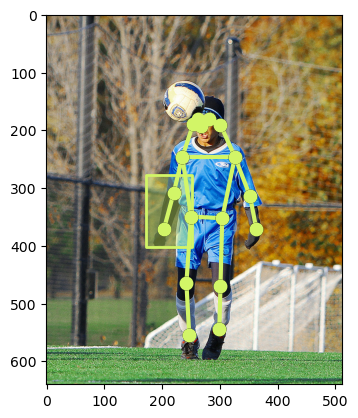

In [43]:
# random.seed(429)
person_sample = random.sample(sorted(coco.getImgIds(catIds=[1])), 1)[0]
person_sample = 111756  # 168215, 26817, 178557, 345100, 115146, 555537, 431555, 245415, 111756
person_sample

# Let's select one image to visualize
img_id = person_sample
annotation_ids = coco.getAnnIds(imgIds=img_id, catIds=[1])
annotation_id = annotation_ids[0]
len(annotation_ids), annotation_ids[0]

loaded_annotations = coco.loadAnns(ids=annotation_ids)
len(loaded_annotations)

# download image 
image_info = coco.loadImgs(img_id)[0]
response = requests.get(image_info['coco_url'])
image = Image.open(BytesIO(response.content))

xmin, ymin, width, height = get_rightarm_bbox(loaded_annotations[0])

original_keypoints = loaded_annotations[0]['keypoints']

print(f"xmin: {xmin}")
print(f"head present? {is_head_present(loaded_annotations[0])}")
print(f"leftarm present? {is_leftarm_present(loaded_annotations[0])}")
print(f"original bbox: {loaded_annotations[0]['bbox']}")
print(f"head bbox: {[xmin, ymin, width, height]}")


original_annotation = {
    # 'keypoints': [0 for _ in range(57)], 
    'keypoints': original_keypoints, 
    # 'bbox': loaded_annotations[0]['bbox'],
    'bbox': [xmin, ymin, width, height], 
    # 'bbox': [232.6, 34.29, 50, 200], 
    'category_id': 1, 
}

print(f"image id: {person_sample}")
plt.imshow(image)
# plt.axis('off')
coco.showAnns([original_annotation], draw_bbox=True)

# according to 206431 need to also consider shoulders most likely
# silly examples: 369872, 178166, 567671, 471771, 548882
# sideways: 455328, 189376, 503021

In [31]:
# Function to create Pascal-style XML annotations
# def create_head_xml(img_info, annotations, output_annotation_dir, categories):
def create_head_xml(img_id):
    """
    Generates a Pascal VOC-style XML file for a given image and its annotations.

    Args:
    - img_info (dict): Image metadata from COCO.
    - annotations (list): List of annotations for the image.
    - output_annotation_dir (str): Directory to save the XML file.
    - categories (list): List of category names to include in the annotations.
    """

    # we can just get the img info and annotations directly here
    img_info = coco_all_anno.loadImgs(img_id)[0]
    annotation_ids = coco_all_anno.getAnnIds(img_id)

    xml_root = Element('annotation')
    folder = SubElement(xml_root, 'folder')
    folder.text = 'VOC2007'

    filename = SubElement(xml_root, 'filename')
    filename.text = img_info['file_name']

    # default source
    source = SubElement(xml_root, 'source')
    database = SubElement(source, 'database')
    database.text = 'COCO Database'

    image = SubElement(source, 'image')
    image.text = 'flickr'

    annotation_tag = SubElement(source, 'annotation')
    annotation_tag.text = 'PASCAL VOC2007'

    flicker_id = SubElement(source, 'flickerid')
    flicker_id.text = '341012865'

    # default owner
    owner = SubElement(xml_root, 'owner')
    flicker_id = SubElement(owner, 'flickerid')
    flicker_id.text = 'Default owner'
    owner_name = SubElement(owner, 'name')
    owner_name.text = 'Default ownername'

    size = SubElement(xml_root, 'size')
    SubElement(size, 'width').text = str(img_info['width'])
    SubElement(size, 'height').text = str(img_info['height'])
    SubElement(size, 'depth').text = '3'  # Assuming RGB images

    segmented = SubElement(xml_root, 'segmented')
    segmented.text = '0'

    for ann_id in annotation_ids:
        # if person, load from coco, else load from coco_all_anno
        ann = coco_all_anno.loadAnns(ann_id)[0]
        # Include only objects in the specified categories
        cat_id = ann['category_id']
        if cat_id not in id_categories.keys():
            continue

        cat_name = id_categories[cat_id]

        # for parts, 
        # {'head': [[]], 'torso': [[]], 'upperarm': [[], []]}
        # for non person, 
        # {'car': [[]]}
        category_bbox = defaultdict(list)

        # Bounding box (bbox) depends on the parts 
        # the same annotation could be used for different parts 
        if cat_name == 'person':
            ann = coco.loadAnns(ann_id)[0]
            original_bbox = ann['bbox']
            # person 
            category_bbox['person'].append(original_bbox)
            # head 
            if is_head_present(ann):
                bbox = get_head_bbox(ann)
                category_bbox['head'].append(bbox)
            # arm
            if is_leftarm_present(ann):
                bbox = get_leftarm_bbox(ann)
                category_bbox['arm'].append(bbox)
            if is_rightarm_present(ann):
                bbox = get_rightarm_bbox(ann)
                category_bbox['arm'].append(bbox)
        else:
            bbox = ann['bbox']  # COCO format: [xmin, ymin, width, height]
            category_bbox[cat_name].append(bbox)

        for final_category, bboxes in category_bbox.items():
            for bbox in bboxes:
                x_min = bbox[0]
                y_min = bbox[1]
                x_max = bbox[0] + bbox[2]
                y_max = bbox[1] + bbox[3]
        
                obj = SubElement(xml_root, 'object')
                name = SubElement(obj, 'name')
                name.text = final_category  # Category name from COCO annotation
        
                # Default difficulty 0
                difficult = SubElement(obj, 'difficult')
                difficult.text = '0'
                
                # Default pose and truncated values
                pose = SubElement(obj, 'pose')
                pose.text = 'Unspecified'
        
                truncated = SubElement(obj, 'truncated')
                is_truncated = (
                    x_min < 0 or y_min < 0 or x_max > img_info['width'] or y_max > img_info['height']
                )
                truncated.text = '1' if is_truncated else '0'
        
                # Bounding box
                bndbox = SubElement(obj, 'bndbox')
                SubElement(bndbox, 'xmin').text = str(max(0, int(x_min)))  # Clip to image boundaries
                SubElement(bndbox, 'ymin').text = str(max(0, int(y_min)))
                SubElement(bndbox, 'xmax').text = str(min(img_info['width'], int(x_max)))
                SubElement(bndbox, 'ymax').text = str(min(img_info['height'], int(y_max)))

    # If no relevant annotations, skip saving the XML
    if not any(cat_name in categories for ann in annotations):
        print(f"Skipping XML generation for {img_info['file_name']} - no relevant annotations.")
        return

    # Pretty format 
    asstring = tostring(xml_root, 'utf-8')
    parsed_xml = parseString(asstring)
    pretty_xml = parsed_xml.toprettyxml(indent="\t")

    # Remove the XML declaration manually
    pretty_xml = '\n'.join(pretty_xml.splitlines()[1:])

    # Save XML
    output_file = os.path.join(annotations_dir, f"{os.path.splitext(img_info['file_name'])[0]}.xml")
    with open(output_file, 'w') as f:
        f.write(pretty_xml)


In [38]:
head_instance_target = 400
arm_instance_target = 4
num_images_per_category = 200

In [39]:
# To freshly download (erase existing data) 
clear_folder(annotations_dir)
clear_folder(sets_dir)
clear_folder(images_dir)

In [40]:
# Define split ratios
train_ratio = 0
val_ratio = 0
test_ratio = 1

all_images = set()
# Track globally selected image IDs to avoid duplicates
globally_selected_image_ids = set()
random.seed(429)

# Prepare data structures
# train_txt_path = os.path.join(sets_dir, "train.txt")
# category_txt_files = {category: open(os.path.join(sets_dir, f"{category}_train.txt"), "w") for category in categories}
positive_samples = defaultdict(set)
annotations_by_image = {}

# Prepare split-specific data structures
splits = {
    "train": {"image_ids": set(), "annotations": {}, "images": set()},
    "val": {"image_ids": set(), "annotations": {}, "images": set()},
    "test": {"image_ids": set(), "annotations": {}, "images": set()},
    "trainval": {"image_ids": set(), "annotations": {}, "images": set()}
}

# Ensure image directory exists
os.makedirs(images_dir, exist_ok=True)

# Process each category
for category, category_id in tqdm(category_ids.items(), desc="Processing categories"):
    print(f"Processing category: {category}")
    
    # Handle 'person' category separately
    if category == 'person':
        head_counter = 0
        arm_counter = 0
        selected_image_ids = []
        image_ids = coco.getImgIds(catIds=[category_id])
        random.shuffle(image_ids)

        # Collect images until the instance target is reached
        for img_id in image_ids:
            # print(f"Person count now: {instance_count}")
            if img_id in globally_selected_image_ids:
                continue
                
            # if this image only contains person and head / arm is not present 
            # then skip 
            ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=[category_id])
            la = coco.loadAnns(ann_ids)
            # let us only get the images that only have shoulder and above
            mask = [is_only_head_present(ann) for ann in la]
            # print(f"mask: {sum(mask)}, len(la): {len(la)}")
            if sum(mask) != len(la):
                # print("not chos")
                continue
            
            # person_count = len(ann_ids)
            head_count = sum([is_head_present(ann) for ann in la])
            leftarm_count = sum([is_leftarm_present(ann) for ann in la])
            rightarm_count = sum([is_rightarm_present(ann) for ann in la])
            arm_count = leftarm_count + rightarm_count
            # if arm_count == 0 and head_count == 0:
            if head_count == 0:
                continue
            # if head_counter + head_count <= head_instance_target or arm_counter + arm_count <= arm_instance_target:
            if head_counter + head_count <= head_instance_target:
                selected_image_ids.append(img_id)
                globally_selected_image_ids.add(img_id)
                head_counter += head_count
                arm_counter += arm_count
            else:
                break
                
        print(f"Selected {len(selected_image_ids)} images to meet {head_counter} 'head' instances and {arm_counter} 'arm' instances.")
        
    else:
        # Default behavior for other categories
        # With the addition that we don't want person in that image also 
        image_ids = coco_all_anno.getImgIds(catIds=[category_id])
        random.shuffle(image_ids)
        selected_image_ids = []
        for img_id in image_ids:
            if img_id in globally_selected_image_ids:
                continue
            categories_in_img = [ann['category_id'] for ann in coco_all_anno.loadAnns(coco_all_anno.getAnnIds(imgIds=[img_id]))]
            if 1 in categories_in_img:
                continue
            selected_image_ids.append(img_id)
            globally_selected_image_ids.add(img_id)
            if len(selected_image_ids) >= num_images_per_category:
                break
    print(f"Selected {len(selected_image_ids)} unique images for category {category}.")

    # Split selected images into train, val, and test
    random.shuffle(selected_image_ids)
    num_images = len(selected_image_ids)
    train_end = int(num_images * train_ratio)
    val_end = train_end + int(num_images * val_ratio)
    print(f"num_immages: {num_images}, train_end: {train_end}, val_end: {val_end}")

    splits["train"]["image_ids"].update(selected_image_ids[:train_end])
    splits["val"]["image_ids"].update(selected_image_ids[train_end:val_end])
    splits["test"]["image_ids"].update(selected_image_ids[val_end:])

    # Collect annotations and positive samples
    for split in ["train", "val", "test"]:
        for img_id in splits[split]["image_ids"]:
            annotations = coco_all_anno.loadAnns(coco_all_anno.getAnnIds(imgIds=[img_id]))
            person_annotations = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))
            splits[split]["annotations"][img_id] = annotations
            splits[split]["images"].add(
                os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
            )
            # Update positive samples that are non person
            for ann in annotations:
                cat_id = ann['category_id']
                if cat_id != 1 and cat_id in id_categories.keys():
                    positive_samples[id_categories[cat_id]].add(
                        os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
                    )
            # Update positive samples that are person
            for ann in person_annotations:
                # check for head part
                if ann['category_id'] == 1 and is_head_present(ann):
                    positive_samples['head'].add(
                        os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
                    )
                # check for arm part
                if ann['category_id'] == 1 and (is_leftarm_present(ann) or is_rightarm_present(ann)):
                    positive_samples['arm'].add(
                        os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
                    )

# Create trainval split (combine train and val)
splits["trainval"]["image_ids"] = splits["train"]["image_ids"].union(splits["val"]["image_ids"])
splits["trainval"]["annotations"] = {**splits["train"]["annotations"], **splits["val"]["annotations"]}
splits["trainval"]["images"] = splits["train"]["images"].union(splits["val"]["images"])

# Download images and create XML annotations for each split
for split, data in splits.items():
    for img_id, annotations in tqdm(data["annotations"].items(), desc=f"Processing {split} images"):
        img_info = coco.loadImgs(img_id)[0]
        img_filename = os.path.splitext(img_info['file_name'])[0]
        img_filepath = os.path.join(images_dir, img_info['file_name'])

        # Download the image if not already downloaded
        if img_filename not in all_images:
            if not os.path.exists(img_filepath):
                try:
                    response = requests.get(img_info['coco_url'], stream=True, timeout=10)
                    response.raise_for_status()
                    with open(img_filepath, 'wb') as f:
                        for chunk in response.iter_content(1024):
                            f.write(chunk)
                except requests.exceptions.RequestException as e:
                    print(f"Failed to download {img_info['file_name']}: {e}")
                    continue  # Skip this image on failure

            all_images.add(img_filename)

        # Generate XML annotation
        # create_pascal_xml(img_info, annotations, annotations_dir, categories)
        # create_head_xml(img_info, annotations, head_annotations_dir, categories)
        create_head_xml(img_id)

# Write ImageSets files for each split
for split, data in splits.items():
    txt_path = os.path.join(sets_dir, f"{split}.txt")
    with open(txt_path, "w") as file:
        for img_filename in sorted(data["images"]):
            file.write(f"{img_filename}\n")

    # Write category-specific files
    for category in categories:
        if category == 'person':
            continue
        category_txt_path = os.path.join(sets_dir, f"{category}_{split}.txt")
        with open(category_txt_path, "w") as category_file:
            for img_filename in sorted(data["images"]):
                label = "1" if img_filename in positive_samples[category] else "-1"
                category_file.write(f"{img_filename} {label}\n")

print(f"ImageSets for train, val, test, and trainval created at {sets_dir}.")


Processing categories:   5%|▉                    | 1/22 [00:00<00:05,  3.80it/s]

Processing category: person
Selected 371 images to meet 400 'head' instances and 4 'arm' instances.
Selected 371 unique images for category person.
num_immages: 371, train_end: 0, val_end: 0
Processing category: bicycle


Processing categories:  18%|███▊                 | 4/22 [00:00<00:02,  7.93it/s]

Selected 200 unique images for category bicycle.
num_immages: 200, train_end: 0, val_end: 0
Processing category: car
Selected 200 unique images for category car.
num_immages: 200, train_end: 0, val_end: 0
Processing category: motorcycle
Selected 200 unique images for category motorcycle.
num_immages: 200, train_end: 0, val_end: 0
Processing category: airplane
Selected 200 unique images for category airplane.
num_immages: 200, train_end: 0, val_end: 0
Processing category: bus


Processing categories:  32%|██████▋              | 7/22 [00:00<00:01, 12.35it/s]

Selected 200 unique images for category bus.
num_immages: 200, train_end: 0, val_end: 0
Processing category: train
Selected 200 unique images for category train.
num_immages: 200, train_end: 0, val_end: 0
Processing category: boat
Selected 200 unique images for category boat.
num_immages: 200, train_end: 0, val_end: 0
Processing category: bird
Selected 200 unique images for category bird.
num_immages: 200, train_end: 0, val_end: 0


Processing categories:  50%|██████████          | 11/22 [00:01<00:00, 13.81it/s]

Processing category: cat
Selected 200 unique images for category cat.
num_immages: 200, train_end: 0, val_end: 0
Processing category: dog
Selected 200 unique images for category dog.
num_immages: 200, train_end: 0, val_end: 0
Processing category: horse
Selected 200 unique images for category horse.
num_immages: 200, train_end: 0, val_end: 0
Processing category: sheep
Selected 200 unique images for category sheep.
num_immages: 200, train_end: 0, val_end: 0


Processing categories:  68%|█████████████▋      | 15/22 [00:01<00:00, 12.88it/s]

Processing category: cow
Selected 200 unique images for category cow.
num_immages: 200, train_end: 0, val_end: 0
Processing category: bottle
Selected 200 unique images for category bottle.
num_immages: 200, train_end: 0, val_end: 0
Processing category: chair
Selected 200 unique images for category chair.
num_immages: 200, train_end: 0, val_end: 0


Processing categories:  77%|███████████████▍    | 17/22 [00:01<00:00, 11.24it/s]

Processing category: couch
Selected 200 unique images for category couch.
num_immages: 200, train_end: 0, val_end: 0
Processing category: potted plant
Selected 200 unique images for category potted plant.
num_immages: 200, train_end: 0, val_end: 0
Processing category: dining table


Processing categories:  95%|███████████████████ | 21/22 [00:01<00:00, 11.66it/s]

Selected 200 unique images for category dining table.
num_immages: 200, train_end: 0, val_end: 0
Processing category: head
Selected 0 unique images for category head.
num_immages: 0, train_end: 0, val_end: 0
Processing category: torso
Selected 0 unique images for category torso.
num_immages: 0, train_end: 0, val_end: 0
Processing category: arm
Selected 0 unique images for category arm.
num_immages: 0, train_end: 0, val_end: 0


Processing categories: 100%|████████████████████| 22/22 [00:01<00:00, 11.21it/s]
Processing train images: 0it [00:00, ?it/s]
Processing val images: 0it [00:00, ?it/s]
Processing test images: 100%|███████████████| 3971/3971 [11:13<00:00,  5.90it/s]
Processing trainval images: 0it [00:00, ?it/s]


ImageSets for train, val, test, and trainval created at /Users/junitasirait/dpmp/VOCdevkit/VOC2007_coco/ImageSets/Main.


### Torso

### Lower arm

### Lower legs

### Playground

In [42]:
coco.loadImgs(ids=[10948])

[{'license': 6,
  'file_name': '000000010948.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000010948.jpg',
  'height': 376,
  'width': 500,
  'date_captured': '2013-11-22 00:28:09',
  'flickr_url': 'http://farm1.staticflickr.com/121/305482790_d063783500_z.jpg',
  'id': 10948}]

In [43]:
coco.getAnnIds(imgIds=[10948])

[47931,
 99444,
 200424,
 235251,
 1334779,
 1510594,
 1629956,
 1973648,
 1974781,
 1974896,
 1991653]

In [53]:
[a['category_id'] for a in coco.loadAnns([
     47931,
     99444,
     200424,
     235251,
     1334779,
     1510594,
     1629956,
     1973648,
     1974781,
     1974896,
     1991653
])]

[17, 63, 1, 1, 2, 47, 75, 75, 75, 75, 85]

In [45]:
category_ids

{'person': 1,
 'bicycle': 2,
 'car': 3,
 'motorcycle': 4,
 'airplane': 5,
 'bus': 6,
 'train': 7,
 'boat': 9,
 'bird': 16,
 'cat': 17,
 'dog': 18,
 'horse': 19,
 'sheep': 20,
 'cow': 21,
 'bottle': 44,
 'chair': 62,
 'couch': 63,
 'potted plant': 64,
 'dining table': 67}

In [60]:
coco.loadAnns(47931)

[{'segmentation': [[321.99,
    258.37,
    317.94,
    252.85,
    318.68,
    248.07,
    320.89,
    242.18,
    324.2,
    239.98,
    330.82,
    238.5,
    335.6,
    233.72,
    342.22,
    233.72,
    348.1,
    234.09,
    351.04,
    235.19,
    348.47,
    229.68,
    356.56,
    229.68,
    359.5,
    231.52,
    366.49,
    230.05,
    370.17,
    230.41,
    372.74,
    234.09,
    371.27,
    239.24,
    373.11,
    244.76,
    372.38,
    246.96,
    371.64,
    248.8,
    372.01,
    252.85,
    372.01,
    256.16,
    375.32,
    259.1,
    375.69,
    262.04,
    372.38,
    263.15,
    368.33,
    263.88,
    365.02,
    265.72,
    362.08,
    264.99,
    360.97,
    263.15,
    356.93,
    263.88,
    348.47,
    265.35,
    342.59,
    266.09,
    340.01,
    267.56,
    334.86,
    267.93,
    330.82,
    266.82,
    326.04,
    264.99,
    324.2,
    263.51,
    322.36,
    260.2,
    320.15,
    258.0]],
  'area': 1648.8485,
  'iscrowd': 0,
  'image_id': 10948